In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [3]:
import lanelines
import straightlanespipeline as slp 

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [4]:
def move_line(line, delta_x):

    x1, y1, x2, y2 = line
    
    return np.array([
        x1 + delta_x,
        y1,
        x2 + delta_x,
        y2
    ])


def define_flat_plane_on_road(images, x_offset=100):
    
    runner = CompGraphRunner(
        slp.computational_graph, 
        frozen_tokens=slp.parameters
    )
    
    left_lines = []
    right_lines = []
    for im in images:
        runner.run(image=im)
        left = move_line(runner['avg_line_left'], -x_offset)
        right = move_line(runner['avg_line_right'], x_offset)
        
        left_lines.append(left)
        right_lines.append(right)
        
    avg_left = np.array(left_lines).mean(axis=0)
    avg_right = np.array(right_lines).mean(axis=0)
    
    res = np.array([
        avg_left[:2],
        avg_right[:2],
        avg_right[2:],
        avg_left[2:],
    ], dtype=np.float32)
        
    return res


def warp_road_image(im, canvas_sz, src, dst):

    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(im, M, canvas_sz, flags=cv2.INTER_LINEAR)

In [5]:
im_straight_1 = lanelines.open_image('test_images/straight_lines1.jpg')
im_straight_2 = lanelines.open_image('test_images/straight_lines2.jpg')

test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]

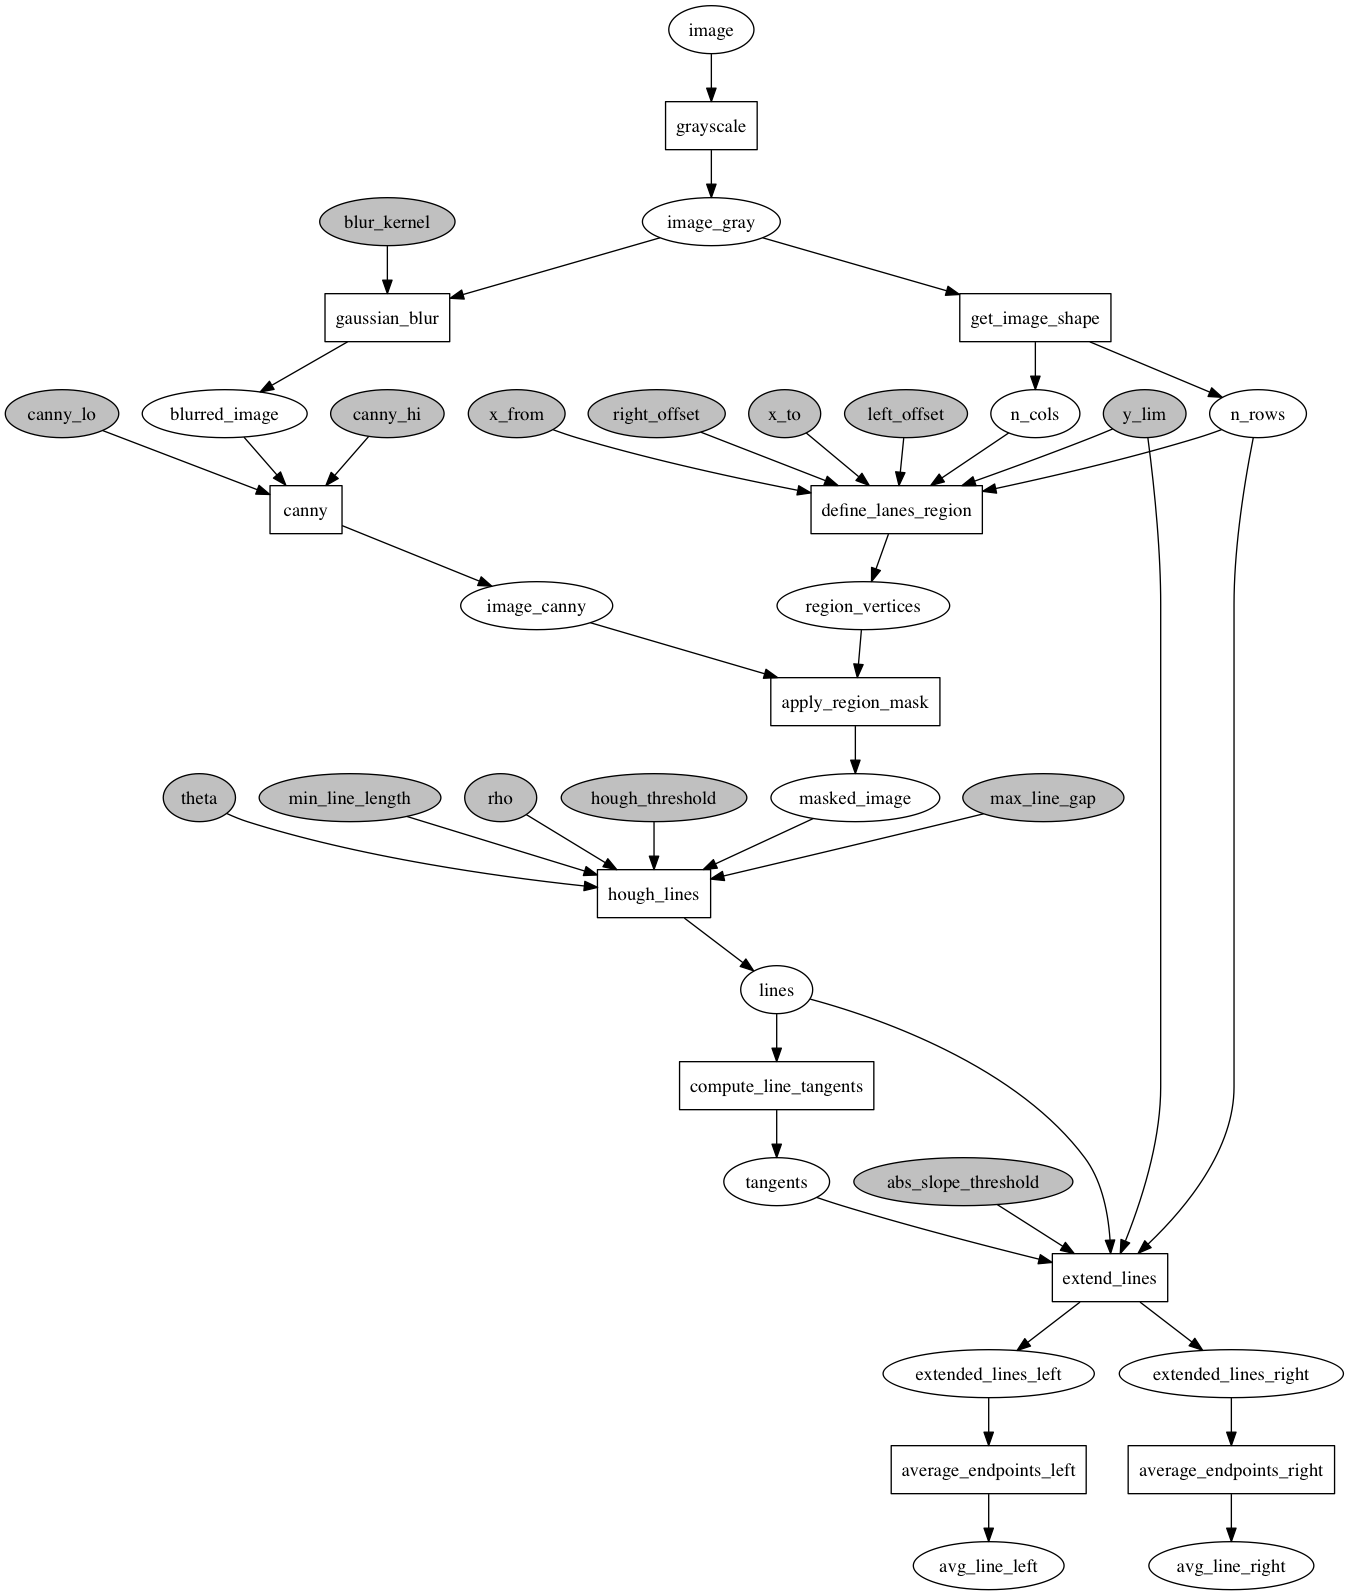

In [6]:
cg = slp.computational_graph
cg_params = slp.parameters

runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

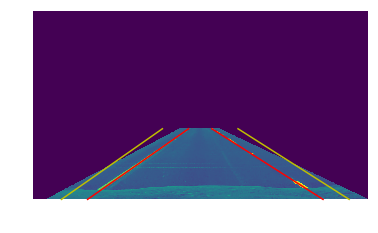

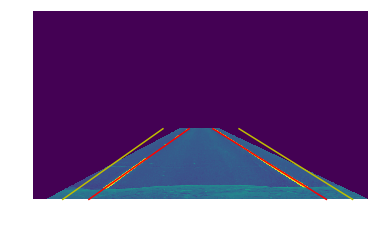

In [7]:
for im in (im_straight_1, im_straight_2):
    runner.run(image=im)
    
    plt.figure()
    plt.imshow( lanelines.apply_region_mask(runner['image_gray'], runner['region_vertices']) )
    plt.axis("off")
    
    lanelines.plot_line(runner['avg_line_left'], color='r')
    lanelines.plot_line(runner['avg_line_right'], color='r')
    
    lanelines.plot_line( move_line(runner['avg_line_left'], -100), color='y')
    lanelines.plot_line( move_line(runner['avg_line_right'], 100), color='y')

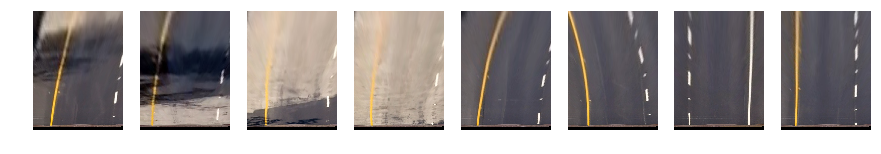

In [8]:
src = define_flat_plane_on_road((im_straight_1, im_straight_2), x_offset=0)
#src[0] += 0.2
canvas_sz = (600, 800)
dst = lanelines.get_rectangle_corners_in_image(canvas_sz, offset_x=100, offset_y=20)

plt.figure(figsize=(15, 5))
for i, im in enumerate(test_images):
    plt.subplot(1, 8, i+1)
    warped = warp_road_image(im, canvas_sz, src, dst)
    plt.imshow( cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )
    plt.axis('off')